In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns
from sys import path
path.insert(0,'../src/')
from glob import glob

from chemulator import Chemulator

# Initializing the Emulator

Chemulator has a simple initialization function that simple takes the path the directory where a chemical encoder is stored. In this case, we'll point it to the autoencoder from the Holdship et al. 2021 release paper.

The resulting emulator object can either be used to create a whole new emulator of the ```load_model``` function can be used to load a pre-trained model/ensemble. Here, we'll use the emulator used for the performance metrics of the release paper.

In [2]:
autoencoder_dir="../models/autoencoder-2021-release/"
emulator=Chemulator(autoencoder_dir=autoencoder_dir)
emulator.load_model("../models/emulator-2021-release/")

In [26]:
#import the actual dataset for the initial conditions of the predictions
#and for the benchmarking

data=pd.read_hdf("example_models.hdf",key="df").reset_index(drop=True)
data

model       Time  gas_density  gas_temp dust_temp            av  \
0      6939     1000.0       2548.6     71.53      10.0  2.455700e-21   
1      6939     2000.0       2548.6    143.13     11.56  2.455700e-21   
2      6939     3000.0       2548.6     77.07     11.56  2.455700e-21   
3      6939     4000.0       2548.6     52.04     11.56  2.455700e-21   
4      6939     5000.0       2548.6     41.72     11.56  2.455700e-21   
...     ...        ...          ...       ...       ...           ...   
9997   4951   996000.0     989240.0    100.00     15.02  1.818800e-04   
9998   4951   997000.0     989240.0    100.00     15.02  1.818800e-04   
9999   4951   998000.0     989240.0     99.95     15.02  1.818800e-04   
10000  4951   999000.0     989240.0     99.82     15.02  1.818800e-04   
10001  4951  1000000.0     989240.0    101.04     15.02  1.818800e-04   

       radfield      zeta         H            H+  ...       MG+  \
0      0.870462  2.253720  0.082356  1.691810e-08  ...  0.000044   
1      0.870462  2.253720  0.600815  2.050690e-07  ...  0.000044   
2      0.870462  2.253720  0.821727  2.591190e-07  ...  0.000044   
3      0.870462  2.253720  0.916669  5.381340e-07  ...  0.000044   
4      0.870462  2.253720  0.957926  7.702370e-07  ...  0.000044   
...         ...       ...       ...           ...  ...       ...   
9997   3.222924  1.917344  0.044288  1.090620e-09  ...  0.000008   
9998   3.222924  1.917344  0.044271  1.084560e-09  ...  0.000008   
9999   3.222924  1.917344  0.044270  1.084390e-09  ...  0.000008   
10000  3.222924  1.917344  0.044274  1.085810e-09  ...  0.000008   
10001  3.222924  1.917344  0.044284  1.089250e-09  ...  0.000008   

                CO+            CO          HCO+            O2           O2+  \
0      3.584520e-13  1.805500e-07  1.256760e-11  1.660070e-10  1.430850e-14   
1      4.747840e-13  3.937840e-08  2.172240e-12  1.437690e-10  2.427510e-14   
2      1.003860e-12  5.880830e-08  5.979380e-12  2.442260e-10  1.866310e-13   
3      4.781420e-13  2.503280e-08  4.993680e-13  1.365850e-10  5.641730e-14   
4      4.422410e-13  1.968780e-08  1.554400e-13  1.326230e-10  1.686190e-14   
...             ...           ...           ...           ...           ...   
9997   3.464270e-15  3.740030e-05  1.879980e-12  1.153870e-10  1.765000e-15   
9998   3.461970e-15  3.740030e-05  1.884360e-12  1.151710e-10  1.763940e-15   
9999   3.461900e-15  3.740030e-05  1.884470e-12  1.151650e-10  1.763910e-15   
10000  3.462430e-15  3.740030e-05  1.883440e-12  1.152150e-10  1.764160e-15   
10001  3.463730e-15  3.740040e-05  1.880960e-12  1.153390e-10  1.764760e-15   

             E-       coldens         h2col          ccol  
0      0.000274  3.904811e+00  5.069267e-08  1.109323e-07  
1      0.000315  3.904811e+00  5.069267e-08  1.109323e-07  
2      0.000322  3.904811e+00  5.069267e-08  1.109323e-07  
3      0.000317  3.904811e+00  5.069267e-08  1.109323e-07  
4      0.000313  3.904811e+00  5.069267e-08  1.109323e-07  
...         ...           ...           ...           ...  
9997   0.000018  2.892011e+17  8.560156e+14  1.856038e+04  
9998   0.000018  2.892011e+17  8.560156e+14  1.856038e+04  
9999   0.000018  2.892011e+17  8.560156e+14  1.856038e+04  
10000  0.000018  2.892011e+17  8.560156e+14  1.856038e+04  
10001  0.000018  2.892011e+17  8.560156e+14  1.856038e+04  

[10002 rows x 45 columns]

In [27]:
# We set uo the starting time
t0=1000
tf=1e6
#Now the indexes where the models star at t0
index=data[(data["Time"]==t0)].index
steps=int((tf-t0)/1000.0)-1

In [28]:
steps

998

In [51]:
index

Int64Index([0, 1001, 2001, 3001, 4002, 5002, 6002, 7002, 8002, 9002], dtype='int64')

In [52]:
#Now lets prepare the different evaluations for each model
init_cond=[]
for i in index:
    init_cond.append(emulator.prepare_inputs(
        data.loc[i:i].reset_index(drop=True),learn_scaling=False)
    )

1/1 [==============================] - 0s 27ms/step


In [53]:
init_cond[0]

gas_temp  gas_density  radfield      zeta  coldens  h2col  ccol  \
0   0.26824     0.481258  0.156591  0.392139      0.0    0.0   0.0   

   metallicity    Chem_1   Chem_2    Chem_3    Chem_4    Chem_5    Chem_6  \
0     0.818681  0.018243  0.18437  0.231199  0.313566  0.625941  0.046221   

     Chem_7    Chem_8  
0  0.114786  0.414637

In [59]:
predictions=[]
for cond in init_cond:
    pred=pd.DataFrame() #The empty dataFrame to fill it up with the prediction o each model
    for step in range(steps):
        output = emulator.predict_multiple_timesteps(cond,1)
        pred=pred.append(output,sort=False) #esto evalua el modelo
        cond["gas_temp"]=output["gas_temp"]#estas dos, actualizan las condiciones por las actuales
        cond[emulator.chem_labels]=output[emulator.chem_labels]
    predictions.append(pred)

1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 33ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 28ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 29ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 36ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 28ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 28ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 30ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 28ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 38ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 34ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 33ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 33ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 32ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 48ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 50ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 44ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 32ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 38ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 39ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 39ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 41ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 47ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 42ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 28ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 37ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 33ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 39ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 45ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 32ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 33ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 40ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 36ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 33ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 46ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 39ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 32ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 38ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 43ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 47ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 38ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 32ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 45ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 37ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 42ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 36ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 40ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 41ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 38ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 42ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 45ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 43ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 41ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 42ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 43ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 43ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 39ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 41ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 34ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 47ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 40ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 40ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 36ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 42ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 42ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 34ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 35ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 34ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 44ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 38ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 39ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 35ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 30ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 29ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 30ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 34ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 32ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 33ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 47ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 29ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 32ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 32ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 30ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 34ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 32ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 28ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 28ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 30ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 30ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 28ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 28ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 31ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 20ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 33ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 31ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo
/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_4170/2802365366.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


In [66]:
predictions[0]

gas_temp  dust_temp    Chem_1    Chem_2    Chem_3    Chem_4    Chem_5  \
0   0.323340   0.046861  0.089558  0.214184  0.199239  0.259192  0.551654   
0   0.296016   0.046280  0.187809  0.230471  0.180393  0.237709  0.472173   
0   0.264866   0.044731  0.256820  0.223538  0.168968  0.219961  0.411643   
0   0.247459   0.042913  0.307566  0.207190  0.160027  0.210022  0.366328   
0   0.236116   0.043225  0.337677  0.189774  0.153676  0.203082  0.332598   
..       ...        ...       ...       ...       ...       ...       ...   
0   0.159269   0.066445  0.474548  0.071213  0.097718  0.135136  0.063451   
0   0.159269   0.066445  0.474548  0.071213  0.097718  0.135136  0.063451   
0   0.159269   0.066445  0.474548  0.071213  0.097718  0.135136  0.063451   
0   0.159269   0.066445  0.474548  0.071213  0.097718  0.135136  0.063451   
0   0.159269   0.066445  0.474548  0.071213  0.097718  0.135136  0.063451   

      Chem_6    Chem_7    Chem_8  
0   0.030150  0.120160  0.449957  
0   0.031956  0.100255  0.456932  
0   0.032014  0.083186  0.461867  
0   0.031597  0.075893  0.464471  
0   0.030373  0.078603  0.465814  
..       ...       ...       ...  
0   0.022501  0.373185  0.471837  
0   0.022501  0.373185  0.471837  
0   0.022501  0.373185  0.471837  
0   0.022501  0.373185  0.471837  
0   0.022501  0.373185  0.471837  

[998 rows x 10 columns]

In [67]:
#We save the model predictions for every model
n=0
for j in predictions:
    n=n+1
    j.to_csv(f'pred_model{str(n)}.csv')  

---

## Now lets plt every one of the evolutionsfor each model

In [141]:
model1=pd.read_csv('pred_model3.csv')
model1=model1.drop('Unnamed: 0',axis=1)
model1

gas_temp  dust_temp    Chem_1    Chem_2    Chem_3    Chem_4    Chem_5  \
0    0.174833   0.083276  0.520434  0.197053  0.186746  0.349683  0.875661   
1    0.142563   0.063560  0.539852  0.235357  0.186853  0.381432  0.871682   
2    0.117226   0.048364  0.565977  0.278996  0.187060  0.403357  0.872922   
3    0.101608   0.039528  0.596360  0.311980  0.184715  0.421082  0.879756   
4    0.085645   0.033822  0.629950  0.327659  0.182693  0.434764  0.888392   
..        ...        ...       ...       ...       ...       ...       ...   
993  0.008413   0.026084  0.865134  0.281598  0.125343  0.510783  0.685897   
994  0.008413   0.026084  0.865134  0.281598  0.125343  0.510783  0.685897   
995  0.008413   0.026084  0.865134  0.281598  0.125343  0.510783  0.685897   
996  0.008413   0.026084  0.865134  0.281598  0.125343  0.510783  0.685897   
997  0.008413   0.026084  0.865134  0.281598  0.125343  0.510783  0.685897   

       Chem_6    Chem_7    Chem_8  
0    0.061687  0.038430  0.092019  
1    0.065587  0.054049  0.092273  
2    0.069583  0.066203  0.091413  
3    0.070612  0.077098  0.091004  
4    0.069207  0.086735  0.091306  
..        ...       ...       ...  
993  0.017057  0.258989  0.071679  
994  0.017057  0.258989  0.071679  
995  0.017057  0.258989  0.071679  
996  0.017057  0.258989  0.071679  
997  0.017057  0.258989  0.071679  

[998 rows x 10 columns]

In [142]:
index

Int64Index([0, 1001, 2001, 3001, 4002, 5002, 6002, 7002, 8002, 9002], dtype='int64')

In [144]:
#get unscaled predictions
predicted=emulator.recover_real_values(model1)

i=index[2]
#grab the real data to compare
models=data.loc[i:i+998]

32/32 [==============================] - 0s 946us/step


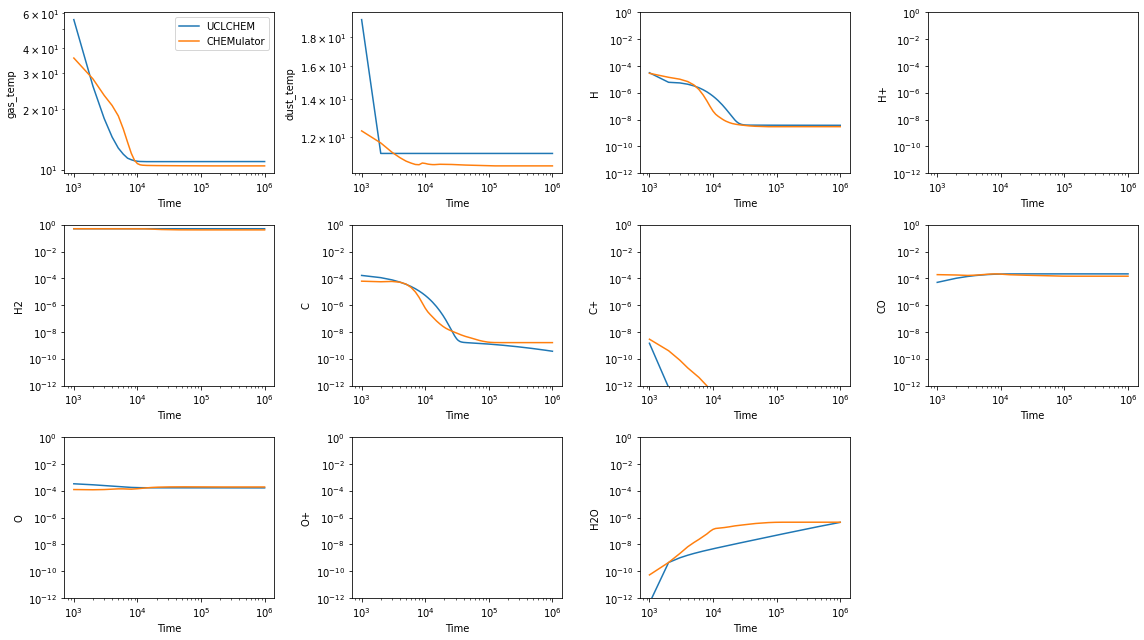

In [145]:
plot_specs=["gas_temp","dust_temp","H","H+","H2","C","C+","CO","O","O+","H2O"]
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
times=[t0+(1000*i+1) for i in range(steps)]
axes=axes.flatten()
for i,ax in enumerate(axes[:-1]):
    ax.plot(models["Time"],models[plot_specs[i]],label="UCLCHEM")
    ax.plot(times,predicted[plot_specs[i]],label="CHEMulator")
    ax.set(xscale="log",yscale="log",xlabel="Time",ylabel=plot_specs[i])
    if i >1:
        ax.set(ylim=(1e-12,1))
axes[0].legend()
axes[-1].remove()

#### Just like that, for every model

For the benchmarking we need the mean o the predicted values for every model. And the standar deviation.

Then lets create an array as follows:

[ [ predicted values gas_temp], [predicted values dust_temp],...]

In [225]:
#Lets recover the true values, every element o this list are the predictions for that model
#true_vals[i] = predictions model i
predicted_vals=[]
for i in range(10):
    model=pd.read_csv(f'pred_model{str(i+1)}.csv')
    model=model.drop('Unnamed: 0',axis=1)
    predicted_vals.append(emulator.recover_real_values(model)[plot_specs])
#predicted_vals=np.array(predicted_vals) #[models,values,variable]

32/32 [==============================] - 0s 1ms/step


In [239]:
real_vals=[]
for i in index:
    real_vals.append(data.loc[i+1:i+998][plot_specs])
#real_vals=np.array(real_vals)

In [240]:
#real_vals.shape
real=pd.concat(real_vals, axis=0)

In [241]:
#predicted_vals.shape
predicted=pd.concat(predicted_vals, axis=0)

In [316]:
elements=[]
for i in plot_specs:
    real_max=max(real[i])
    pred_max=max(predicted[i])
    
    real_min=min(real[i])
    pred_min=min(predicted[i])
    
    step=(real_max - real_min)/30.0
    val=[]
    for j in range(30):
        a = real[i][(real_min+j*step <= real[i]) & (real[i] <= real_min+(j+1)*step)]
        #a = real[i][(real[i] <= real_min+(j+1)*step)] #&((real_min+j*step) <= real[i])].index
        val.append(a)
    elements.append(val)       

In [317]:
elements[0][0]

1        143.13
2         77.07
3         52.04
4         41.72
5         36.45
          ...  
9996      99.77
9997     100.00
9998     100.00
9999      99.95
10000     99.82
Name: gas_temp, Length: 4986, dtype: float64

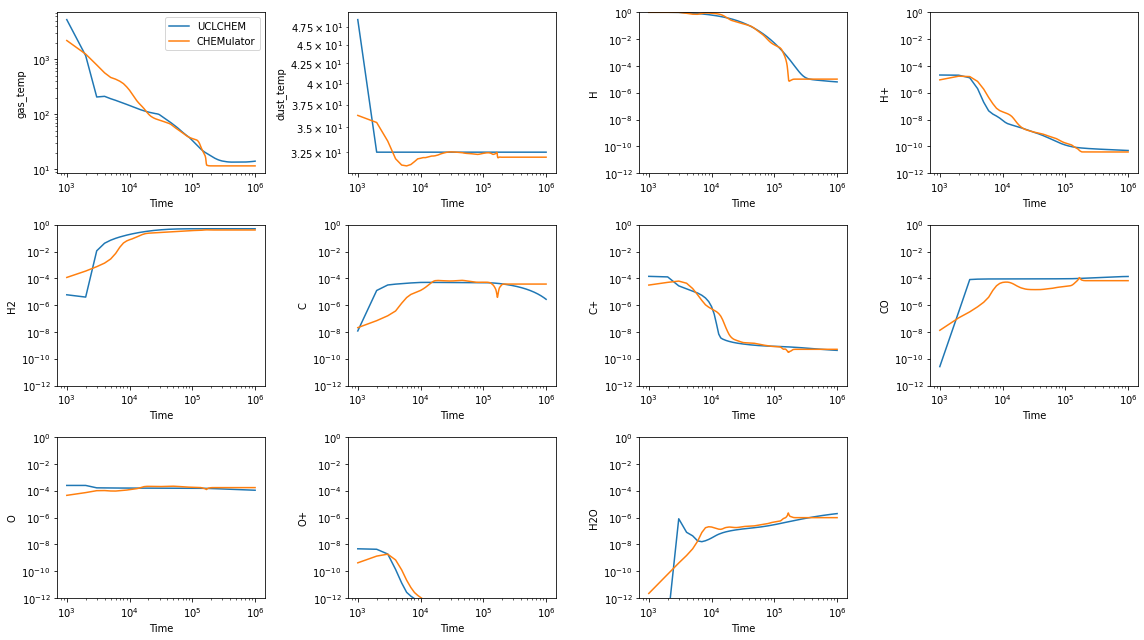

In [129]:
plot_specs=["gas_temp","dust_temp","H","H+","H2","C","C+","CO","O","O+","H2O"]
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
times=[t0+(1000*i+1) for i in range(steps)]
axes=axes.flatten()
for i,ax in enumerate(axes[:-1]):
    ax.plot(models["Time"],real_vals[5][plot_specs[i]],label="UCLCHEM")
    ax.plot(times,predicted_vals[5][plot_specs[i]],label="CHEMulator")
    ax.set(xscale="log",yscale="log",xlabel="Time",ylabel=plot_specs[i])
    if i >1:
        ax.set(ylim=(1e-12,1))
axes[0].legend()
axes[-1].remove()

In [207]:
real_medians=[]
pred_medians=[]
real_sig=[]
pred_sig=[]

for i in range(11): #para cada una de las variables
    real_med=[]
    pred_med=[]
    
    real_s=[]
    pred_s=[]
    for j in range(998): #para cada una de las predicciones
        real_med.append(np.median(real_vals[:,j,i]))
        pred_med.append(np.median(predicted_vals[:,j,i]))
        real_s.append(np.std(real_vals[:,j,i]))
        pred_s.append(np.std(real_vals[:,j,i]))
    real_medians.append(real_med)
    pred_medians.append(pred_med)
    real_sig.append(real_s)
    pred_sig.append(pred_s)
real_sig=np.array(real_sig)
pred_sig =np.array(pred_sig )

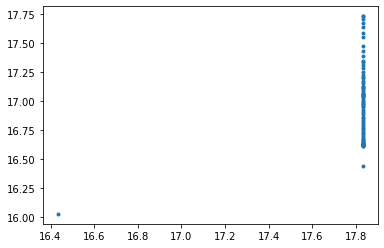

In [208]:
plt.plot(real_medians[1],pred_medians[1],'.')

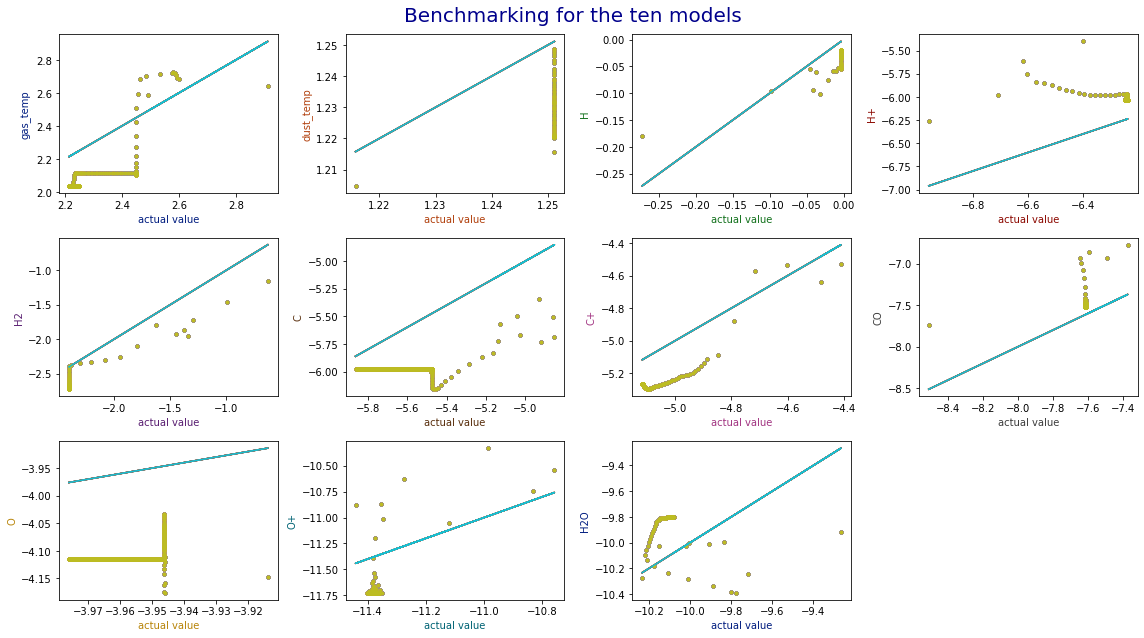

In [214]:
#fig,ax=plt.subplots(figsize=(25,12))
colors=sns.color_palette("dark",n_colors=11)
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
axes=axes.flatten()

for j in range(len(predicted_vals)):
    for i,ax in enumerate(axes[:-1]):
        ax.plot(np.log10(real_medians[i]),np.log10(pred_medians[i]),
                '.')#,label="UCLCHEM",color=colors[i])
        ax.plot(np.log10(real_medians[i]),np.log10(real_medians[i]))
        
        #ax.fill_between(np.log10(real_medians[i]), np.log10(pred_medians[i])-np.log10(real_sig[i]), 
                        #np.log10(pred_medians[i])+np.log(pred_sig[i]))
        
        ax.set(xlabel="actual value",ylabel=plot_specs[i])
        ax.yaxis.label.set_color(colors[i])
        ax.xaxis.label.set_color(colors[i])
fig.suptitle('Benchmarking for the ten models', fontsize=20, color='darkblue')
#ax.legend()
axes[-1].remove()

Vamos a tomar primero los valores del rango de la temperaura, asi podemos encontrar que valores caen en ese rango y ver cual es la prediccion del emulador para cada uno.

vamos a encontrar el rango de cada una de las predicciones:

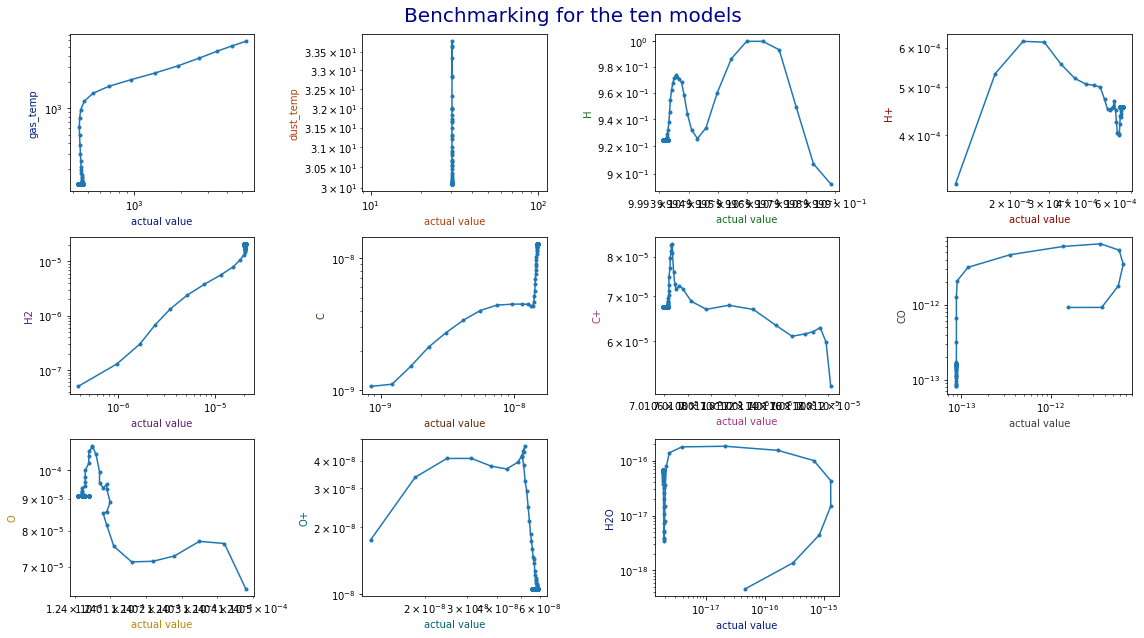

In [216]:
colors=sns.color_palette("dark",n_colors=11)
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
axes=axes.flatten()

model=7

#for j in range(len(predicted_vals)):
for i,ax in enumerate(axes[:-1]):
    #ax.plot(np.log10(real_medians[i]),np.log10(pred_medians[i]),
            #'.')#,label="UCLCHEM",color=colors[i])
    #ax.plot(np.log10(real_medians[i]),np.log10(real_medians[i]))
    ax.plot(real_vals[model,:,i][1:],predicted_vals[model,:,i],'.-')

    ax.set(xscale='log', yscale='log',xlabel="actual value",ylabel=plot_specs[i])
    ax.yaxis.label.set_color(colors[i])
    ax.xaxis.label.set_color(colors[i])
fig.suptitle('Benchmarking for the ten models', fontsize=20, color='darkblue')
#ax.legend()
axes[-1].remove()

Lets work with the ranges of the temperature

In [44]:
predicted_vals.shape

(10, 998, 11)

Now the same for the real ones

In [45]:
real_vals=[]
for i in index:
    real_vals.append(data.loc[i:i+998][plot_specs])
real_vals=np.array(real_vals)

In [46]:
real_vals.shape

(10, 999, 11)

#### Now for the benchmarking of the plot we need the median and the $\sigma$ of every variable of all the models
#### Lets try first with the gas_temp

In [35]:
real_medianT=[]
real_sigmaT=[]
for k in range(998):
    real_medianT.append(np.median(real_vals[:,k,6]))
    real_sigmaT.append(np.std(real_vals[:,k,6]))
real_medianT=np.array(real_medianT)
real_sigmaT=np.array(real_sigmaT)

In [36]:
len(real_medianT)

998

In [37]:
#now the predicted
pred_medianT=[]
pred_sigmaT=[]
for l in range(998):
    pred_medianT.append(np.median(predicted_vals[:,l,6]))
    pred_sigmaT.append(np.std(predicted_vals[:,l,6]))
pred_medianT=np.array(pred_medianT)
pred_sigmaT=np.array(pred_sigmaT)

In [38]:
len(pred_medianT)

998

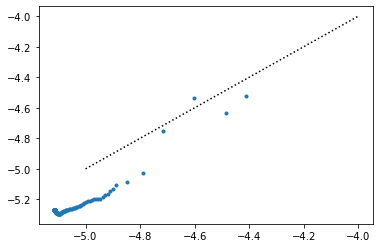

In [39]:
plt.plot(np.log10(real_medianT),np.log10(pred_medianT),'.')
#plt.xscale('log')
#plt.yscale('log')
#xx = [-5,- 4.5,-4]
plt.plot(xx,xx,'k:')

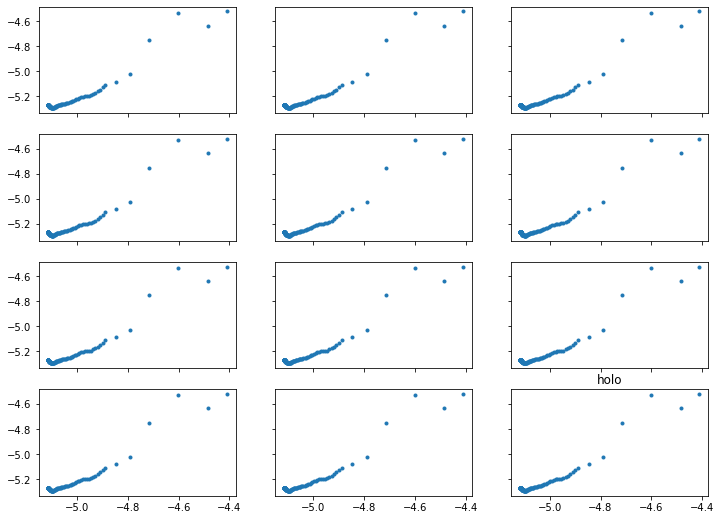

In [44]:
rows, cols = 4, 3
fig, ax = plt.subplots(rows, cols, figsize=(12,9),
                       sharex='col', 
                       sharey='row')
plt.title('holo')
for row in range(rows):
    for col in range(cols):
        ax[row, col].plot(np.log10(real_medianT),np.log10(pred_medianT),'.')

plt.show()

# Benchmarking vs UCLPDR

In [320]:
#this is a file with all the input column densities and the total UV
model_df=pd.read_csv("sine_input.csv")

#We're subsampling UCLPDR output so cut that down
particles=model_df["Particle"]
model_df

Particle       T_g       n_H   H2_abun        C_abun      FUV  \
0          1  100.9120   52570.5  0.006470  1.676530e-06  9.99984   
1         16  102.7800   75087.7  0.050528  2.396100e-06  9.99984   
2         31   86.2791   92354.0  0.328082  3.635100e-06  9.99984   
3         46   74.5608  100606.0  0.421634  4.406570e-06  9.99984   
4         61   71.0860   98044.0  0.439261  4.455190e-06  9.99984   
..       ...       ...       ...       ...           ...      ...   
92      1381   16.8962   22895.8  0.499970  8.677700e-09  9.99984   
93      1396   16.5534   44733.3  0.499982  3.891400e-09  9.99984   
94      1411   14.7481   67936.9  0.499986  2.323510e-09  9.99984   
95      1426   13.8569   87448.4  0.499988  1.709610e-09  9.99984   
96      1441   13.4685   99014.7  0.499989  1.471200e-09  9.99984   

               x       delta_x  delta_h2_col   delta_c_col  delta_col_dens  \
0  -3.180156e+19  0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
1  -3.180156e+19  2.000000e+10  7.588078e+13  3.598353e+09    1.501754e+15   
2  -3.180156e+19  9.999999e+09  3.029968e+14  3.357160e+09    9.235399e+14   
3  -3.180156e+19  9.999999e+09  4.241891e+14  4.433273e+09    1.006060e+15   
4  -3.180156e+19  2.000000e+10  8.613380e+14  8.736092e+09    1.960880e+15   
..           ...           ...           ...           ...             ...   
92  3.180156e+19  2.000000e+10  2.289443e+14  3.973658e+06    4.579160e+14   
93  3.180156e+19  2.000000e+10  4.473169e+14  3.481504e+06    8.946661e+14   
94  3.180156e+19  2.000000e+10  6.793500e+14  3.157042e+06    1.358738e+15   
95  3.180156e+19  9.999999e+09  4.372315e+14  1.495026e+06    8.744839e+14   
96  3.180156e+19  9.999999e+09  4.950626e+14  1.456704e+06    9.901469e+14   

    total_h2_col   total_c_col  total_col_dens          size  
0   0.000000e+00  0.000000e+00    0.000000e+00  0.000000e+00  
1   4.358194e+14  4.665551e+10    2.376777e+16  3.900000e+11  
2   4.352329e+15  1.061395e+11    4.331426e+16  6.200000e+11  
3   1.352157e+16  2.024797e+11    6.671263e+16  8.600000e+11  
4   2.393420e+16  3.103052e+11    9.075010e+16  1.100000e+12  
..           ...           ...             ...           ...  
92  1.026692e+24  3.592001e+17    2.053494e+24  6.360312e+19  
93  1.026692e+24  3.592001e+17    2.053494e+24  6.360312e+19  
94  1.026692e+24  3.592001e+17    2.053494e+24  6.360312e+19  
95  1.026692e+24  3.592001e+17    2.053494e+24  6.360312e+19  
96  1.026692e+24  3.592001e+17    2.053494e+24  6.360312e+19  

[97 rows x 15 columns]

#### $\texttt{model_df}$ will be the inputs of the model, and particles is the array made up from the kind of particles used here. uclpdr contains the evolution of every particle (from 0 to 1462), then lets sampling the particles from the full uclpdr


In [321]:
uclpdr=pd.read_csv("sine_output.csv")
idx=uclpdr["Particle"].isin(particles)
uclpdr=uclpdr.loc[idx].reset_index(drop=True)

In [322]:
uclpdr

Particle       n_H           n_g       T_g      T_d       FUV  F_x  \
0          1   52570.5  1.051410e-07  100.9120  20.9745  10.00000  0.0   
1         16   75087.7  1.501750e-07  102.7800  20.9743   9.99955  0.0   
2         31   92354.0  1.847080e-07   86.2791  20.9742   9.99919  0.0   
3         46  100606.0  2.012110e-07   74.5608  20.9740   9.99874  0.0   
4         61   98044.0  1.960880e-07   71.0860  20.9738   9.99829  0.0   
..       ...       ...           ...       ...      ...       ...  ...   
92      1381   22895.8  4.579170e-08   16.8962  10.0000   0.00000  0.0   
93      1396   44733.3  8.946670e-08   16.5534  10.0000   0.00000  0.0   
94      1411   67936.9  1.358740e-07   14.7481  10.0000   0.00000  0.0   
95      1426   87448.4  1.748970e-07   13.8569  10.0000   0.00000  0.0   
96      1441   99014.7  1.980290e-07   13.4685  10.0000   0.00000  0.0   

             Av      H3+_abun      He+_abun  ...  n(o-H2,15)_pop  \
0      0.000000  8.374400e-15  1.020870e-08  ...    5.984800e-17   
1      0.000015  3.371460e-13  5.735650e-09  ...    0.000000e+00   
2      0.000027  8.096680e-12  2.191460e-09  ...    2.214890e-14   
3      0.000042  1.090440e-11  1.774270e-09  ...    1.038060e-14   
4      0.000057  1.179950e-11  1.797420e-09  ...    0.000000e+00   
..          ...           ...           ...  ...             ...   
92  1298.830000  1.984620e-09  5.237500e-10  ...    1.778770e-18   
93  1298.830000  1.143490e-09  2.634240e-10  ...    0.000000e+00   
94  1298.830000  8.057020e-10  1.721080e-10  ...    7.216720e-19   
95  1298.830000  6.497690e-10  1.331480e-10  ...    0.000000e+00   
96  1298.830000  5.839870e-10  1.173680e-10  ...    1.218030e-18   

    n(o-H2,16)_pop  n(o-H2,17)_pop  n(o-H2,18)_pop  n(o-H2,19)_pop  \
0     2.609020e-15    3.176370e-21    3.953920e-22    2.344590e-18   
1     3.552710e-14    4.607860e-19    3.970470e-22    1.962410e-17   
2     6.714630e-13    7.453890e-18    2.562270e-20    0.000000e+00   
3     0.000000e+00    0.000000e+00    2.541100e-21    1.925540e-16   
4     0.000000e+00    7.074420e-18    2.964620e-21    3.027090e-16   
..             ...             ...             ...             ...   
92    0.000000e+00    5.459390e-22    4.771030e-27    0.000000e+00   
93    0.000000e+00    1.756930e-21    0.000000e+00    0.000000e+00   
94    0.000000e+00    0.000000e+00    1.186450e-26    6.352750e-22   
95    8.673620e-18    4.764560e-22    8.633290e-27    0.000000e+00   
96    4.054920e-17    3.308720e-24    0.000000e+00    1.318200e-20   

    n(o-H2,20)_pop  n(o-H2,21)_pop  n(o-H2,22)_pop  n(o-H2,23)_pop  \
0     2.206570e-15    2.710510e-20    4.839880e-16    2.456730e-22   
1     0.000000e+00    0.000000e+00    6.605830e-15    0.000000e+00   
2     0.000000e+00    1.019150e-17    6.239450e-14    5.493000e-25   
3     2.611240e-13    0.000000e+00    6.328270e-14    1.113240e-26   
4     0.000000e+00    6.017320e-18    2.642330e-14    3.811780e-27   
..             ...             ...             ...             ...   
92    5.589060e-17    4.400860e-24    2.238880e-17    1.604370e-59   
93    0.000000e+00    7.935760e-24    1.664250e-17    3.313760e-59   
94    0.000000e+00    9.512580e-24    0.000000e+00    0.000000e+00   
95    0.000000e+00    2.998530e-24    6.830470e-18    8.828900e-60   
96    2.569560e-17    0.000000e+00    0.000000e+00    2.683680e-60   

    n(o-H2,24)_pop  
0     4.496400e-14  
1     5.506710e-13  
2     1.847410e-13  
3     1.278980e-13  
4     0.000000e+00  
..             ...  
92    2.775560e-16  
93    4.440890e-16  
94    0.000000e+00  
95    5.811320e-17  
96    8.716990e-16  

[97 rows x 696 columns]

### Now we add the rest of the variables. This is, the inputs needed for the emulator

In [144]:
#then fill in other physics
model_df["zeta"]=3.84
model_df["metallicity"]=1.0
model_df=model_df[['T_g', 'n_H',"FUV","zeta",'total_col_dens','total_h2_col','total_c_col' ]]
model_df.columns=['gas_temp','gas_density','radfield','zeta','coldens','h2col','ccol']
model_df["radfield"]=1.7*model_df["radfield"] #UCLPDR in Draine, our code in Habing

/var/tmp/rojasolvera/ipykernel_3467/383046222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["radfield"]=1.7*model_df["radfield"] #UCLPDR in Draine, our code in Habing


In [145]:
init_cond[0]

gas_temp  gas_density  radfield      zeta  coldens  h2col  ccol  \
0   0.26824     0.481258  0.156591  0.392139      0.0    0.0   0.0   

   metallicity    Chem_1   Chem_2    Chem_3    Chem_4    Chem_5    Chem_6  \
0     0.818681  0.018243  0.18437  0.231199  0.313566  0.625941  0.046221   

     Chem_7    Chem_8  
0  0.114786  0.414637

In [146]:
model_df

gas_temp  gas_density   radfield  zeta       coldens         h2col  \
0   100.9120      52570.5  16.999728  3.84  0.000000e+00  0.000000e+00   
1   102.7800      75087.7  16.999728  3.84  2.376777e+16  4.358194e+14   
2    86.2791      92354.0  16.999728  3.84  4.331426e+16  4.352329e+15   
3    74.5608     100606.0  16.999728  3.84  6.671263e+16  1.352157e+16   
4    71.0860      98044.0  16.999728  3.84  9.075010e+16  2.393420e+16   
..       ...          ...        ...   ...           ...           ...   
92   16.8962      22895.8  16.999728  3.84  2.053494e+24  1.026692e+24   
93   16.5534      44733.3  16.999728  3.84  2.053494e+24  1.026692e+24   
94   14.7481      67936.9  16.999728  3.84  2.053494e+24  1.026692e+24   
95   13.8569      87448.4  16.999728  3.84  2.053494e+24  1.026692e+24   
96   13.4685      99014.7  16.999728  3.84  2.053494e+24  1.026692e+24   

            ccol  
0   0.000000e+00  
1   4.665551e+10  
2   1.061395e+11  
3   2.024797e+11  
4   3.103052e+11  
..           ...  
92  3.592001e+17  
93  3.592001e+17  
94  3.592001e+17  
95  3.592001e+17  
96  3.592001e+17  

[97 rows x 7 columns]

In [147]:
#we can add chemistry by setting all the species the autoencoder expects to 0
#Aqui se esta rellenando con la quimica, porque esta base de datos no tenia esas columnas de inicio
#Se estan llenando con puros ceros, para luego poner los valores que queremos
for spec in emulator.autoencoder.species:
    model_df[spec]=0.0

#aqui se ponen los valores que queremos, utilizando un loop
initial_abunds={
    "H":0.4,
    "H2":0.3,
    "HE":0.1,
    "C+":1.0e-4,
    "O":3.0e-4,
    "MG":5.00e-06,
    "E-":1.0e-4
}

for spec,abund in initial_abunds.items():
    model_df[spec]=abund
model_df=emulator.prepare_inputs(model_df,learn_scaling=False) #Luego se hace el encoding para que puedan ser ingresadas al emulador
model_df[model_df<0]=0.0 #se desprecian las abundancias negativas y ahora 

4/4 [==============================] - 0s 2ms/step


/var/tmp/rojasolvera/ipykernel_3467/3832802032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[spec]=0.0
/var/tmp/rojasolvera/ipykernel_3467/3832802032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[spec]=0.0
/var/tmp/rojasolvera/ipykernel_3467/3832802032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Asi que el resultado es un total de 96 condiciones iniciales que corresponden a 96 diferentes especies y que ahora se puede hacer la prediccion de su evolucion:

In [148]:
model_df 

gas_temp  gas_density  radfield      zeta   coldens     h2col      ccol  \
0   0.314680     0.744173  0.371728  0.430715  0.000000  0.000000  0.000000   
1   0.317155     0.775141  0.371728  0.430715  0.152853  0.513949  0.526609   
2   0.293539     0.793120  0.371728  0.430715  0.181816  0.567570  0.544367   
3   0.273840     0.800555  0.371728  0.430715  0.202660  0.593983  0.558321   
4   0.267400     0.798314  0.371728  0.430715  0.217510  0.607289  0.567544   
..       ...          ...       ...       ...       ...       ...       ...   
92  0.073507     0.671968  0.371728  0.430715  1.000000  1.000000  0.869179   
93  0.070741     0.730149  0.371728  0.430715  1.000000  1.000000  0.869179   
94  0.055157     0.766448  0.371728  0.430715  1.000000  1.000000  0.869179   
95  0.046746     0.788379  0.371728  0.430715  1.000000  1.000000  0.869179   
96  0.042909     0.799170  0.371728  0.430715  1.000000  1.000000  0.869179   

    metallicity    Chem_1    Chem_2    Chem_3    Chem_4    Chem_5    Chem_6  \
0      0.634024  0.292424  0.117725  0.201037  0.001036  0.428459  0.044759   
1      0.634024  0.292424  0.117725  0.201037  0.001036  0.428459  0.044759   
2      0.634024  0.292424  0.117725  0.201037  0.001036  0.428459  0.044759   
3      0.634024  0.292424  0.117725  0.201037  0.001036  0.428459  0.044759   
4      0.634024  0.292424  0.117725  0.201037  0.001036  0.428459  0.044759   
..          ...       ...       ...       ...       ...       ...       ...   
92     0.634024  0.292424  0.117725  0.201037  0.001036  0.428459  0.044759   
93     0.634024  0.292424  0.117725  0.201037  0.001036  0.428459  0.044759   
94     0.634024  0.292424  0.117725  0.201037  0.001036  0.428459  0.044759   
95     0.634024  0.292424  0.117725  0.201037  0.001036  0.428459  0.044759   
96     0.634024  0.292424  0.117725  0.201037  0.001036  0.428459  0.044759   

      Chem_7    Chem_8  
0   0.664875  0.038756  
1   0.664875  0.038756  
2   0.664875  0.038756  
3   0.664875  0.038756  
4   0.664875  0.038756  
..       ...       ...  
92  0.664875  0.038756  
93  0.664875  0.038756  
94  0.664875  0.038756  
95  0.664875  0.038756  
96  0.664874  0.038756  

[97 rows x 16 columns]

Ahora el paso de tiempo que se esta evaluando es de #=1000, esto siginifica que las 
predicciones seran para 1e+6 yrs.

In [149]:
output=emulator.predict_multiple_timesteps(model_df,1000)
output=emulator.recover_real_values(output)

4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step


In [150]:
len(output) #este es el numero de especies

97

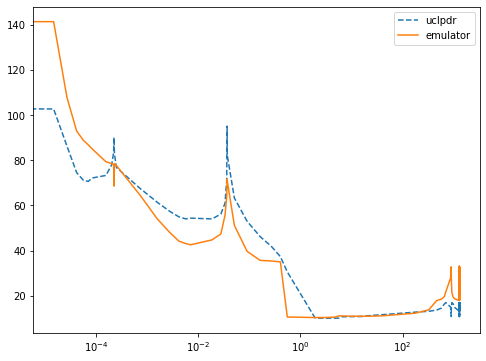

In [167]:
#the first one is the benchmarking of the 'av vs gas temperature'
plt.figure(figsize=(8,6))
plt.plot(uclpdr['Av'],uclpdr['T_g'],label='uclpdr',ls='--')
plt.plot(uclpdr['Av'],output['gas_temp'],label='emulator')
#Notice that the shape of the 'output' depends on the the shape of 'uclpdr'
#And then, the time steps depend on the 'uclpdr' too
plt.xscale('log')
plt.legend()

In [170]:
#Now we do the same with the abundances.
output.columns

Index(['gas_temp', 'dust_temp', 'H', 'H+', 'H2', 'H2+', 'H3+', 'HE', 'HE+',
       'C+', 'C', 'CH', 'CH+', 'CH2', 'CH2+', 'CH3+', 'CH3', 'CH4+', 'O+',
       'CH4', 'O', 'CH5+', 'OH+', 'OH', 'H2O+', 'H2O', 'H3O+', 'MG', 'MG+',
       'CO+', 'CO', 'HCO+', 'O2', 'O2+', 'E-'],
      dtype='object')

In [326]:
len(uclpdr)

97

In [327]:
len(uclpdr['T_g'])

97

In [190]:
from matplotlib.pyplot import cm

In [328]:
#each point(av, abundance) in the following plot corresponds to the av, abundance of a single particle.

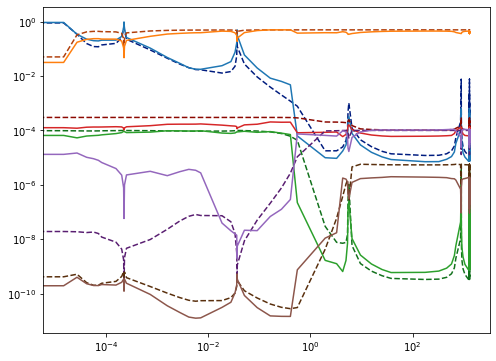

In [217]:
#lets try with the abundances of ["H","H2","C+","O","CO","H2O"]
# the name of the abundances in uclpdr is as follows: {species}_abun
plt.figure(figsize=(8,6))
plt.xscale('log')
plt.yscale('log')
colors=sns.color_palette("dark",n_colors=6)
for k,abun in enumerate(["H","H2","C+","O","CO","H2O"]):
    plt.plot(uclpdr['Av'],uclpdr[f'{abun}_abun'],color=colors[k], ls='--')
    #now the model predictions
    plt.plot(uclpdr['Av'],output[abun])

---
##### Now we do the same with the models presented in the very bening of this notebook

In [8]:
autoencoder_dir="../models/autoencoder-2021-release/"
emulator=Chemulator(autoencoder_dir=autoencoder_dir)
emulator.load_model("../models/emulator-2021-release/")

In [9]:
#import the actual dataset for the initial conditions of the predictions
#and for the benchmarking

data=pd.read_hdf("example_models.hdf",key="df").reset_index(drop=True)
data

model       Time  gas_density  gas_temp dust_temp            av  \
0      6939     1000.0       2548.6     71.53      10.0  2.455700e-21   
1      6939     2000.0       2548.6    143.13     11.56  2.455700e-21   
2      6939     3000.0       2548.6     77.07     11.56  2.455700e-21   
3      6939     4000.0       2548.6     52.04     11.56  2.455700e-21   
4      6939     5000.0       2548.6     41.72     11.56  2.455700e-21   
...     ...        ...          ...       ...       ...           ...   
9997   4951   996000.0     989240.0    100.00     15.02  1.818800e-04   
9998   4951   997000.0     989240.0    100.00     15.02  1.818800e-04   
9999   4951   998000.0     989240.0     99.95     15.02  1.818800e-04   
10000  4951   999000.0     989240.0     99.82     15.02  1.818800e-04   
10001  4951  1000000.0     989240.0    101.04     15.02  1.818800e-04   

       radfield      zeta         H            H+  ...       MG+  \
0      0.870462  2.253720  0.082356  1.691810e-08  ...  0.000044   
1      0.870462  2.253720  0.600815  2.050690e-07  ...  0.000044   
2      0.870462  2.253720  0.821727  2.591190e-07  ...  0.000044   
3      0.870462  2.253720  0.916669  5.381340e-07  ...  0.000044   
4      0.870462  2.253720  0.957926  7.702370e-07  ...  0.000044   
...         ...       ...       ...           ...  ...       ...   
9997   3.222924  1.917344  0.044288  1.090620e-09  ...  0.000008   
9998   3.222924  1.917344  0.044271  1.084560e-09  ...  0.000008   
9999   3.222924  1.917344  0.044270  1.084390e-09  ...  0.000008   
10000  3.222924  1.917344  0.044274  1.085810e-09  ...  0.000008   
10001  3.222924  1.917344  0.044284  1.089250e-09  ...  0.000008   

                CO+            CO          HCO+            O2           O2+  \
0      3.584520e-13  1.805500e-07  1.256760e-11  1.660070e-10  1.430850e-14   
1      4.747840e-13  3.937840e-08  2.172240e-12  1.437690e-10  2.427510e-14   
2      1.003860e-12  5.880830e-08  5.979380e-12  2.442260e-10  1.866310e-13   
3      4.781420e-13  2.503280e-08  4.993680e-13  1.365850e-10  5.641730e-14   
4      4.422410e-13  1.968780e-08  1.554400e-13  1.326230e-10  1.686190e-14   
...             ...           ...           ...           ...           ...   
9997   3.464270e-15  3.740030e-05  1.879980e-12  1.153870e-10  1.765000e-15   
9998   3.461970e-15  3.740030e-05  1.884360e-12  1.151710e-10  1.763940e-15   
9999   3.461900e-15  3.740030e-05  1.884470e-12  1.151650e-10  1.763910e-15   
10000  3.462430e-15  3.740030e-05  1.883440e-12  1.152150e-10  1.764160e-15   
10001  3.463730e-15  3.740040e-05  1.880960e-12  1.153390e-10  1.764760e-15   

             E-       coldens         h2col          ccol  
0      0.000274  3.904811e+00  5.069267e-08  1.109323e-07  
1      0.000315  3.904811e+00  5.069267e-08  1.109323e-07  
2      0.000322  3.904811e+00  5.069267e-08  1.109323e-07  
3      0.000317  3.904811e+00  5.069267e-08  1.109323e-07  
4      0.000313  3.904811e+00  5.069267e-08  1.109323e-07  
...         ...           ...           ...           ...  
9997   0.000018  2.892011e+17  8.560156e+14  1.856038e+04  
9998   0.000018  2.892011e+17  8.560156e+14  1.856038e+04  
9999   0.000018  2.892011e+17  8.560156e+14  1.856038e+04  
10000  0.000018  2.892011e+17  8.560156e+14  1.856038e+04  
10001  0.000018  2.892011e+17  8.560156e+14  1.856038e+04  

[10002 rows x 45 columns]

In [11]:
topten=[]
for model in data['model'].unique():
    
    
    
    

SyntaxError: incomplete input (1204551858.py, line 2)

In [13]:
data[data['model']=='4951']

model       Time  gas_density  gas_temp dust_temp        av  radfield  \
9002   4951     1000.0     989240.0     47.48      10.0  0.000182  3.222924   
9003   4951     2000.0     989240.0     99.81     15.02  0.000182  3.222924   
9004   4951     3000.0     989240.0    100.62     15.02  0.000182  3.222924   
9005   4951     4000.0     989240.0    101.19     15.02  0.000182  3.222924   
9006   4951     5000.0     989240.0    101.04     15.02  0.000182  3.222924   
...     ...        ...          ...       ...       ...       ...       ...   
9997   4951   996000.0     989240.0    100.00     15.02  0.000182  3.222924   
9998   4951   997000.0     989240.0    100.00     15.02  0.000182  3.222924   
9999   4951   998000.0     989240.0     99.95     15.02  0.000182  3.222924   
10000  4951   999000.0     989240.0     99.82     15.02  0.000182  3.222924   
10001  4951  1000000.0     989240.0    101.04     15.02  0.000182  3.222924   

           zeta         H            H+  ...       MG+           CO+  \
9002   1.917344  0.004451  9.540340e-11  ...  0.000008  1.138370e-15   
9003   1.917344  0.052104  6.859700e-09  ...  0.000008  5.766280e-15   
9004   1.917344  0.044393  1.078690e-09  ...  0.000008  5.087930e-15   
9005   1.917344  0.044247  1.050210e-09  ...  0.000008  4.953790e-15   
9006   1.917344  0.044201  1.032430e-09  ...  0.000008  4.844050e-15   
...         ...       ...           ...  ...       ...           ...   
9997   1.917344  0.044288  1.090620e-09  ...  0.000008  3.464270e-15   
9998   1.917344  0.044271  1.084560e-09  ...  0.000008  3.461970e-15   
9999   1.917344  0.044270  1.084390e-09  ...  0.000008  3.461900e-15   
10000  1.917344  0.044274  1.085810e-09  ...  0.000008  3.462430e-15   
10001  1.917344  0.044284  1.089250e-09  ...  0.000008  3.463730e-15   

             CO          HCO+            O2           O2+        E-  \
9002   0.000004  1.077600e-11  6.200920e-11  2.107450e-16  0.000016   
9003   0.000006  9.424420e-13  7.275150e-11  4.683060e-16  0.000028   
9004   0.000008  2.111860e-12  4.759170e-11  4.671250e-16  0.000031   
9005   0.000010  2.111720e-12  4.834630e-11  4.845780e-16  0.000030   
9006   0.000012  2.108210e-12  4.934560e-11  5.043260e-16  0.000030   
...         ...           ...           ...           ...       ...   
9997   0.000037  1.879980e-12  1.153870e-10  1.765000e-15  0.000018   
9998   0.000037  1.884360e-12  1.151710e-10  1.763940e-15  0.000018   
9999   0.000037  1.884470e-12  1.151650e-10  1.763910e-15  0.000018   
10000  0.000037  1.883440e-12  1.152150e-10  1.764160e-15  0.000018   
10001  0.000037  1.880960e-12  1.153390e-10  1.764760e-15  0.000018   

            coldens         h2col          ccol  
9002   2.892011e+17  8.560156e+14  18560.378653  
9003   2.892011e+17  8.560156e+14  18560.378653  
9004   2.892011e+17  8.560156e+14  18560.378653  
9005   2.892011e+17  8.560156e+14  18560.378653  
9006   2.892011e+17  8.560156e+14  18560.378653  
...             ...           ...           ...  
9997   2.892011e+17  8.560156e+14  18560.378653  
9998   2.892011e+17  8.560156e+14  18560.378653  
9999   2.892011e+17  8.560156e+14  18560.378653  
10000  2.892011e+17  8.560156e+14  18560.378653  
10001  2.892011e+17  8.560156e+14  18560.378653  

[1000 rows x 45 columns]

In [10]:
data['model'].unique()

array(['6939', '17604', '4611', '9949', '17967', '4674', '927', '8095',
       '1709', '4951'], dtype=object)

In [318]:
#Now we take the elements of uclpdr for this species
uclpdr=pd.read_csv("sine_output.csv")
#Only one of the species of in the uclpdr dataset
uclpdr=uclpdr[uclpdr["Particle"]==927]

In [319]:
uclpdr

Particle      n_H           n_g      T_g   T_d  FUV  F_x       Av  \
926       927  13494.4  2.698890e-08  16.8962  10.0  0.0  0.0  1296.24   

         H3+_abun      He+_abun  ...  n(o-H2,15)_pop  n(o-H2,16)_pop  \
926  3.023160e-09  9.044680e-10  ...    3.955640e-19    2.265980e-17   

     n(o-H2,17)_pop  n(o-H2,18)_pop  n(o-H2,19)_pop  n(o-H2,20)_pop  \
926    4.652890e-23    2.953500e-27    6.593620e-20             0.0   

     n(o-H2,21)_pop  n(o-H2,22)_pop  n(o-H2,23)_pop  n(o-H2,24)_pop  
926             0.0    3.415240e-18    7.258560e-60    3.647260e-16  

[1 rows x 696 columns]

In [273]:
species

array(['6939', '17604', '4611', '9949', '17967', '4674', '927', '8095',
       '1709', '4951'], dtype=object)

In [274]:
species2=uclpdr['Particle'].unique()

In [288]:
uclpdr["Particle"].isin(species)

0       False
1       False
2       False
3       False
4       False
        ...  
1458    False
1459    False
1460    False
1461    False
1462    False
Name: Particle, Length: 1463, dtype: bool

In [297]:
uclpdr[uclpdr["Particle"]==927]

Particle      n_H           n_g      T_g   T_d  FUV  F_x       Av  \
926       927  13494.4  2.698890e-08  16.8962  10.0  0.0  0.0  1296.24   

         H3+_abun      He+_abun  ...  n(o-H2,15)_pop  n(o-H2,16)_pop  \
926  3.023160e-09  9.044680e-10  ...    3.955640e-19    2.265980e-17   

     n(o-H2,17)_pop  n(o-H2,18)_pop  n(o-H2,19)_pop  n(o-H2,20)_pop  \
926    4.652890e-23    2.953500e-27    6.593620e-20             0.0   

     n(o-H2,21)_pop  n(o-H2,22)_pop  n(o-H2,23)_pop  n(o-H2,24)_pop  
926             0.0    3.415240e-18    7.258560e-60    3.647260e-16  

[1 rows x 696 columns]

In [317]:
uclpdr['H_abun']

926    0.000083
Name: H_abun, dtype: float64

---

### Let's work with the top-ten elements in the dataset. And do its benchmarking

We have 10 different models in the dataset and we can choose the 10 with the highest temperature for each model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns
from sys import path
path.insert(0,'../src/')
from glob import glob

from chemulator import Chemulator

In [2]:
#first, to define the path of the emulator and the encoder
autoencoder_dir="../models/autoencoder-2021-release/"
emulator=Chemulator(autoencoder_dir=autoencoder_dir)
emulator.load_model("../models/emulator-2021-release/")

In [3]:
data=pd.read_hdf("example_models.hdf",key="df").reset_index(drop=True)
#data=data.drop_duplicates('gas_temp').sort_values(by=['gas_temp']) #we sort the values by the gas temperature
data=data.drop_duplicates('gas_temp')

In [11]:
tops=[]
for model in data['model'].unique():
    top=data[data['model']==model]
    tops.append(top.sort_values(by=['gas_temp'])[-10:])
#In tops we have the list of the top-10 elements of each model sorted by temperature of the gas

In [12]:
# Now we have to sorted in time order
models_top=[] #esta lista tendra los valores de cada modelo con mayor temperatura
for top in tops:
    models_top.append(top.sort_values(by=['Time'],ascending=True))
models_top[0]

model      Time  gas_density  gas_temp dust_temp            av  radfield  \
0    6939    1000.0       2548.6     71.53      10.0  2.455700e-21  0.870462   
1    6939    2000.0       2548.6    143.13     11.56  2.455700e-21  0.870462   
2    6939    3000.0       2548.6     77.07     11.56  2.455700e-21  0.870462   
3    6939    4000.0       2548.6     52.04     11.56  2.455700e-21  0.870462   
4    6939    5000.0       2548.6     41.72     11.56  2.455700e-21  0.870462   
5    6939    6000.0       2548.6     36.45     11.56  2.455700e-21  0.870462   
6    6939    7000.0       2548.6     33.56     11.56  2.455700e-21  0.870462   
7    6939    8000.0       2548.6     32.39     11.56  2.455700e-21  0.870462   
33   6939   34000.0       2548.6     32.37     11.56  2.455700e-21  0.870462   
647  6939  648000.0       2548.6     32.36     11.56  2.455700e-21  0.870462   

        zeta         H            H+  ...       MG+           CO+  \
0    2.25372  0.082356  1.691810e-08  ...  0.000044  3.584520e-13   
1    2.25372  0.600815  2.050690e-07  ...  0.000044  4.747840e-13   
2    2.25372  0.821727  2.591190e-07  ...  0.000044  1.003860e-12   
3    2.25372  0.916669  5.381340e-07  ...  0.000044  4.781420e-13   
4    2.25372  0.957926  7.702370e-07  ...  0.000044  4.422410e-13   
5    2.25372  0.976002  9.023620e-07  ...  0.000044  4.660960e-13   
6    2.25372  0.984007  9.588990e-07  ...  0.000044  4.829160e-13   
7    2.25372  0.987599  9.730470e-07  ...  0.000044  4.925320e-13   
33   2.25372  0.990561  9.454890e-07  ...  0.000043  5.021340e-13   
647  2.25372  0.990551  9.479030e-07  ...  0.000043  5.020350e-13   

               CO          HCO+            O2           O2+        E-  \
0    1.805500e-07  1.256760e-11  1.660070e-10  1.430850e-14  0.000274   
1    3.937840e-08  2.172240e-12  1.437690e-10  2.427510e-14  0.000315   
2    5.880830e-08  5.979380e-12  2.442260e-10  1.866310e-13  0.000322   
3    2.503280e-08  4.993680e-13  1.365850e-10  5.641730e-14  0.000317   
4    1.968780e-08  1.554400e-13  1.326230e-10  1.686190e-14  0.000313   
5    2.055120e-08  1.404210e-13  1.395350e-10  9.723830e-15  0.000310   
6    2.169950e-08  1.567140e-13  1.424190e-10  7.952710e-15  0.000308   
7    2.249610e-08  1.732680e-13  1.430440e-10  7.278410e-15  0.000307   
33   2.339310e-08  1.945350e-13  1.426260e-10  6.670280e-15  0.000306   
647  2.338100e-08  1.942510e-13  1.426380e-10  6.678920e-15  0.000306   

      coldens         h2col          ccol  
0    3.904811  5.069267e-08  1.109323e-07  
1    3.904811  5.069267e-08  1.109323e-07  
2    3.904811  5.069267e-08  1.109323e-07  
3    3.904811  5.069267e-08  1.109323e-07  
4    3.904811  5.069267e-08  1.109323e-07  
5    3.904811  5.069267e-08  1.109323e-07  
6    3.904811  5.069267e-08  1.109323e-07  
7    3.904811  5.069267e-08  1.109323e-07  
33   3.904811  5.069267e-08  1.109323e-07  
647  3.904811  5.069267e-08  1.109323e-07  

[10 rows x 45 columns]

**Now for the benchmarking we run the chem for every initial condition.**

Notice that, in each model we have differents timesteps. We will evaluate over all the points between the initial and ending points. Then we take those corresponding to each value. 

Now, let's prepare the initial condition and the number of steps: 

In [104]:
#The initial conditions are the first values of every model:
init_cond=[]
steps=[]
for i in models_top:
    init_cond.append(i.iloc[0])
    paso=[]
    for k in range(9):
        paso.append((i['Time'].iloc[k+1]-i['Time'].iloc[k])/1000.0)
    steps.append(paso)
    
#init_cond contine la informacion de cada una de las condiciones iniciales de cada modelo
#steps tiene los valores en los que tenemos que evaluar el modelo para 'atinarle' a los valores que elegimos 
#por tener las temperaturas mas altas

In [105]:
#We prepare the initial conditions